In [1]:
import os
import sys
import itertools
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd
from scipy.stats import spearmanr

from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns

import torch
from torch import nn, optim
from transformers import BertConfig, BertTokenizer, BertModel, BertForMaskedLM#, BertLayer, BertEmbeddings
from transformers.modeling_bert import BertLayer, BertEmbeddings

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# re-load functions
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%config InlineBackend.figure_formats = {'png', 'retina'}

In [3]:
DEVICE = 'cpu'

In [4]:
ls ../mnt/inputs/nes_info/

ContextualWordEmbsAug_sub_df.pkl  question_body_grp_count.csv
aug_rows.pkl                      question_body_grp_count.pkl
aug_train_1.pkl                   trn_df.pkl


In [5]:
trn_df = pd.read_pickle('../mnt/inputs/nes_info/trn_df.pkl')
display(trn_df.shape, trn_df.head())

(6079, 42)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,question_body_le
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,1.000000,0.333333,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000,143
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,1.000000,1.000000,0.000000,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,0.000000,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889,857
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,0.888889,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.444444,0.333333,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889,2285
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,0.888889,0.666667,0.666667,1.0,1.0,1.0,0.444444,0.444444,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000,155
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com,1.000000,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000,835


In [8]:
trn_df.iloc[0].question_body.split('.')

['After playing around with macro photography on-the-cheap (read: reversed lens, rev',
 ' lens mounted on a straight lens, passive extension tubes), I would like to get further with this',
 ' The problems with the techniques I used is that focus is manual and aperture control is problematic at best',
 ' This limited my setup to still subjects (read: dead insects) Now, as spring is approaching, I want to be able to shoot live insects',
 ' I believe that for this, autofocus and settable aperture will be of great help',
 '\n\nSo, one obvious but expensive option is a macro lens (say, EF 100mm Macro) However, I am not really interested in yet another prime lens',
 ' An alternative is the electrical extension tubes',
 '\n\nExcept for maximum focusing distance, what am I losing when using tubes (coupled with a fine lens, say EF70-200/2',
 '8) instead of a macro lens?\n']

In [9]:
trn_df.host.unique()

array(['photo.stackexchange.com', 'rpg.stackexchange.com',
       'electronics.stackexchange.com', 'judaism.stackexchange.com',
       'graphicdesign.stackexchange.com', 'stackoverflow.com',
       'askubuntu.com', 'gaming.stackexchange.com', 'serverfault.com',
       'unix.stackexchange.com', 'dba.stackexchange.com',
       'codereview.stackexchange.com', 'crypto.stackexchange.com',
       'tex.stackexchange.com', 'travel.stackexchange.com',
       'webapps.stackexchange.com', 'mechanics.stackexchange.com',
       'physics.stackexchange.com', 'math.stackexchange.com',
       'programmers.stackexchange.com', 'biology.stackexchange.com',
       'wordpress.stackexchange.com', 'superuser.com',
       'music.stackexchange.com', 'blender.stackexchange.com',
       'dsp.stackexchange.com', 'drupal.stackexchange.com',
       'meta.stackexchange.com', 'security.stackexchange.com',
       'raspberrypi.stackexchange.com', 'academia.stackexchange.com',
       'bicycles.stackexchange.com', 'androi

In [13]:
label_cols = ['question_asker_intent_understanding', 'question_body_critical',
       'question_conversational', 'question_expect_short_answer',
       'question_fact_seeking', 'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written']

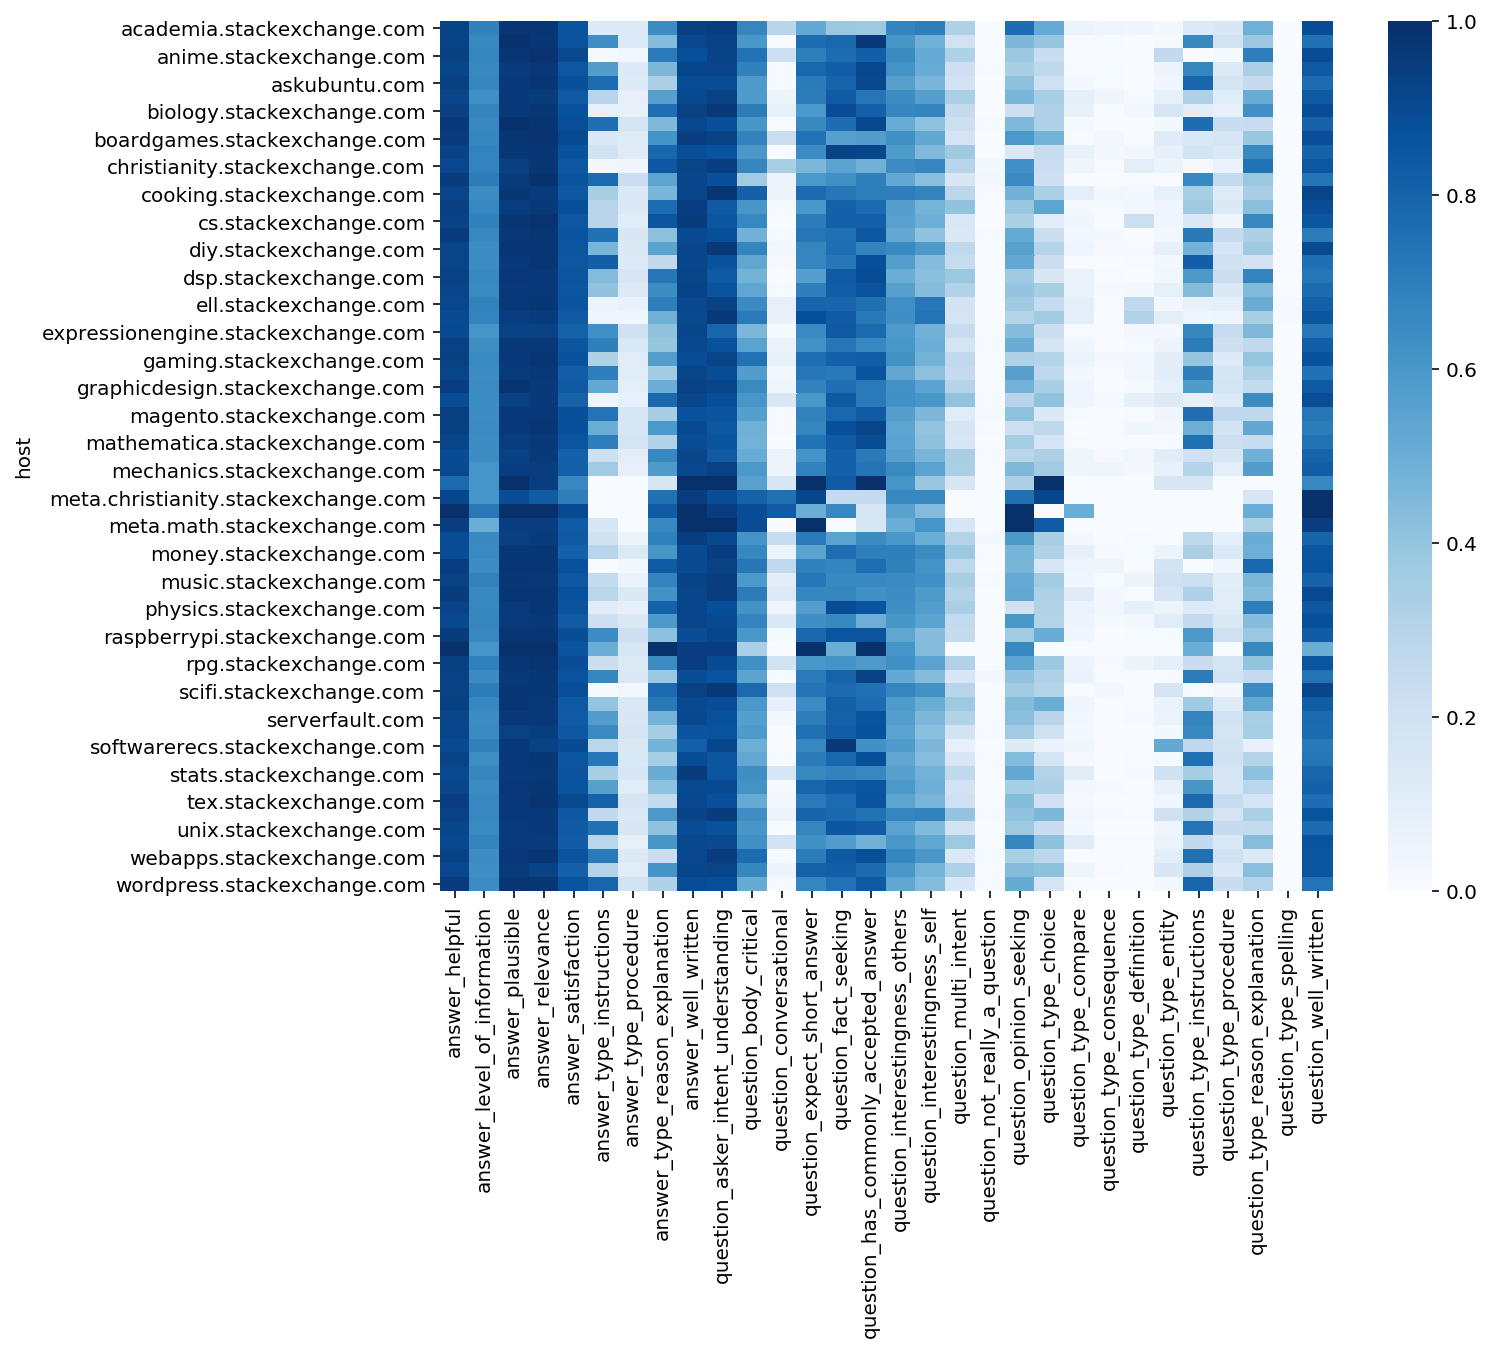

In [22]:
fig = plt.figure(figsize=(10, 8))
sns.heatmap(pd.pivot_table(index='host', data=trn_df, values=label_cols, aggfunc='mean'), cmap='Blues')

In [26]:
pd.pivot_table(index='host', data=trn_df, values=label_cols, aggfunc='count')

,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written
host,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
academia.stackexchange.com,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103
android.stackexchange.com,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36
anime.stackexchange.com,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
apple.stackexchange.com,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106
askubuntu.com,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126
bicycles.stackexchange.com,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75
biology.stackexchange.com,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53
blender.stackexchange.com,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42
boardgames.stackexchange.com,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67


In [27]:
HOSTs = ['stackexchange', 'askubuntu', 'mathoverflow', 'serverfault', 'stackoverflow', 'superuser']

In [31]:
for HOST in HOSTs:
    trn_df.loc[trn_df.host.str.contains(HOST).values, 'HOST'] = HOST

In [45]:
for HOST in HOSTs:
    print(f"'HOST_{HOST},'".casefold())

'host_stackexchange,'
'host_askubuntu,'
'host_mathoverflow,'
'host_serverfault,'
'host_stackoverflow,'
'host_superuser,'


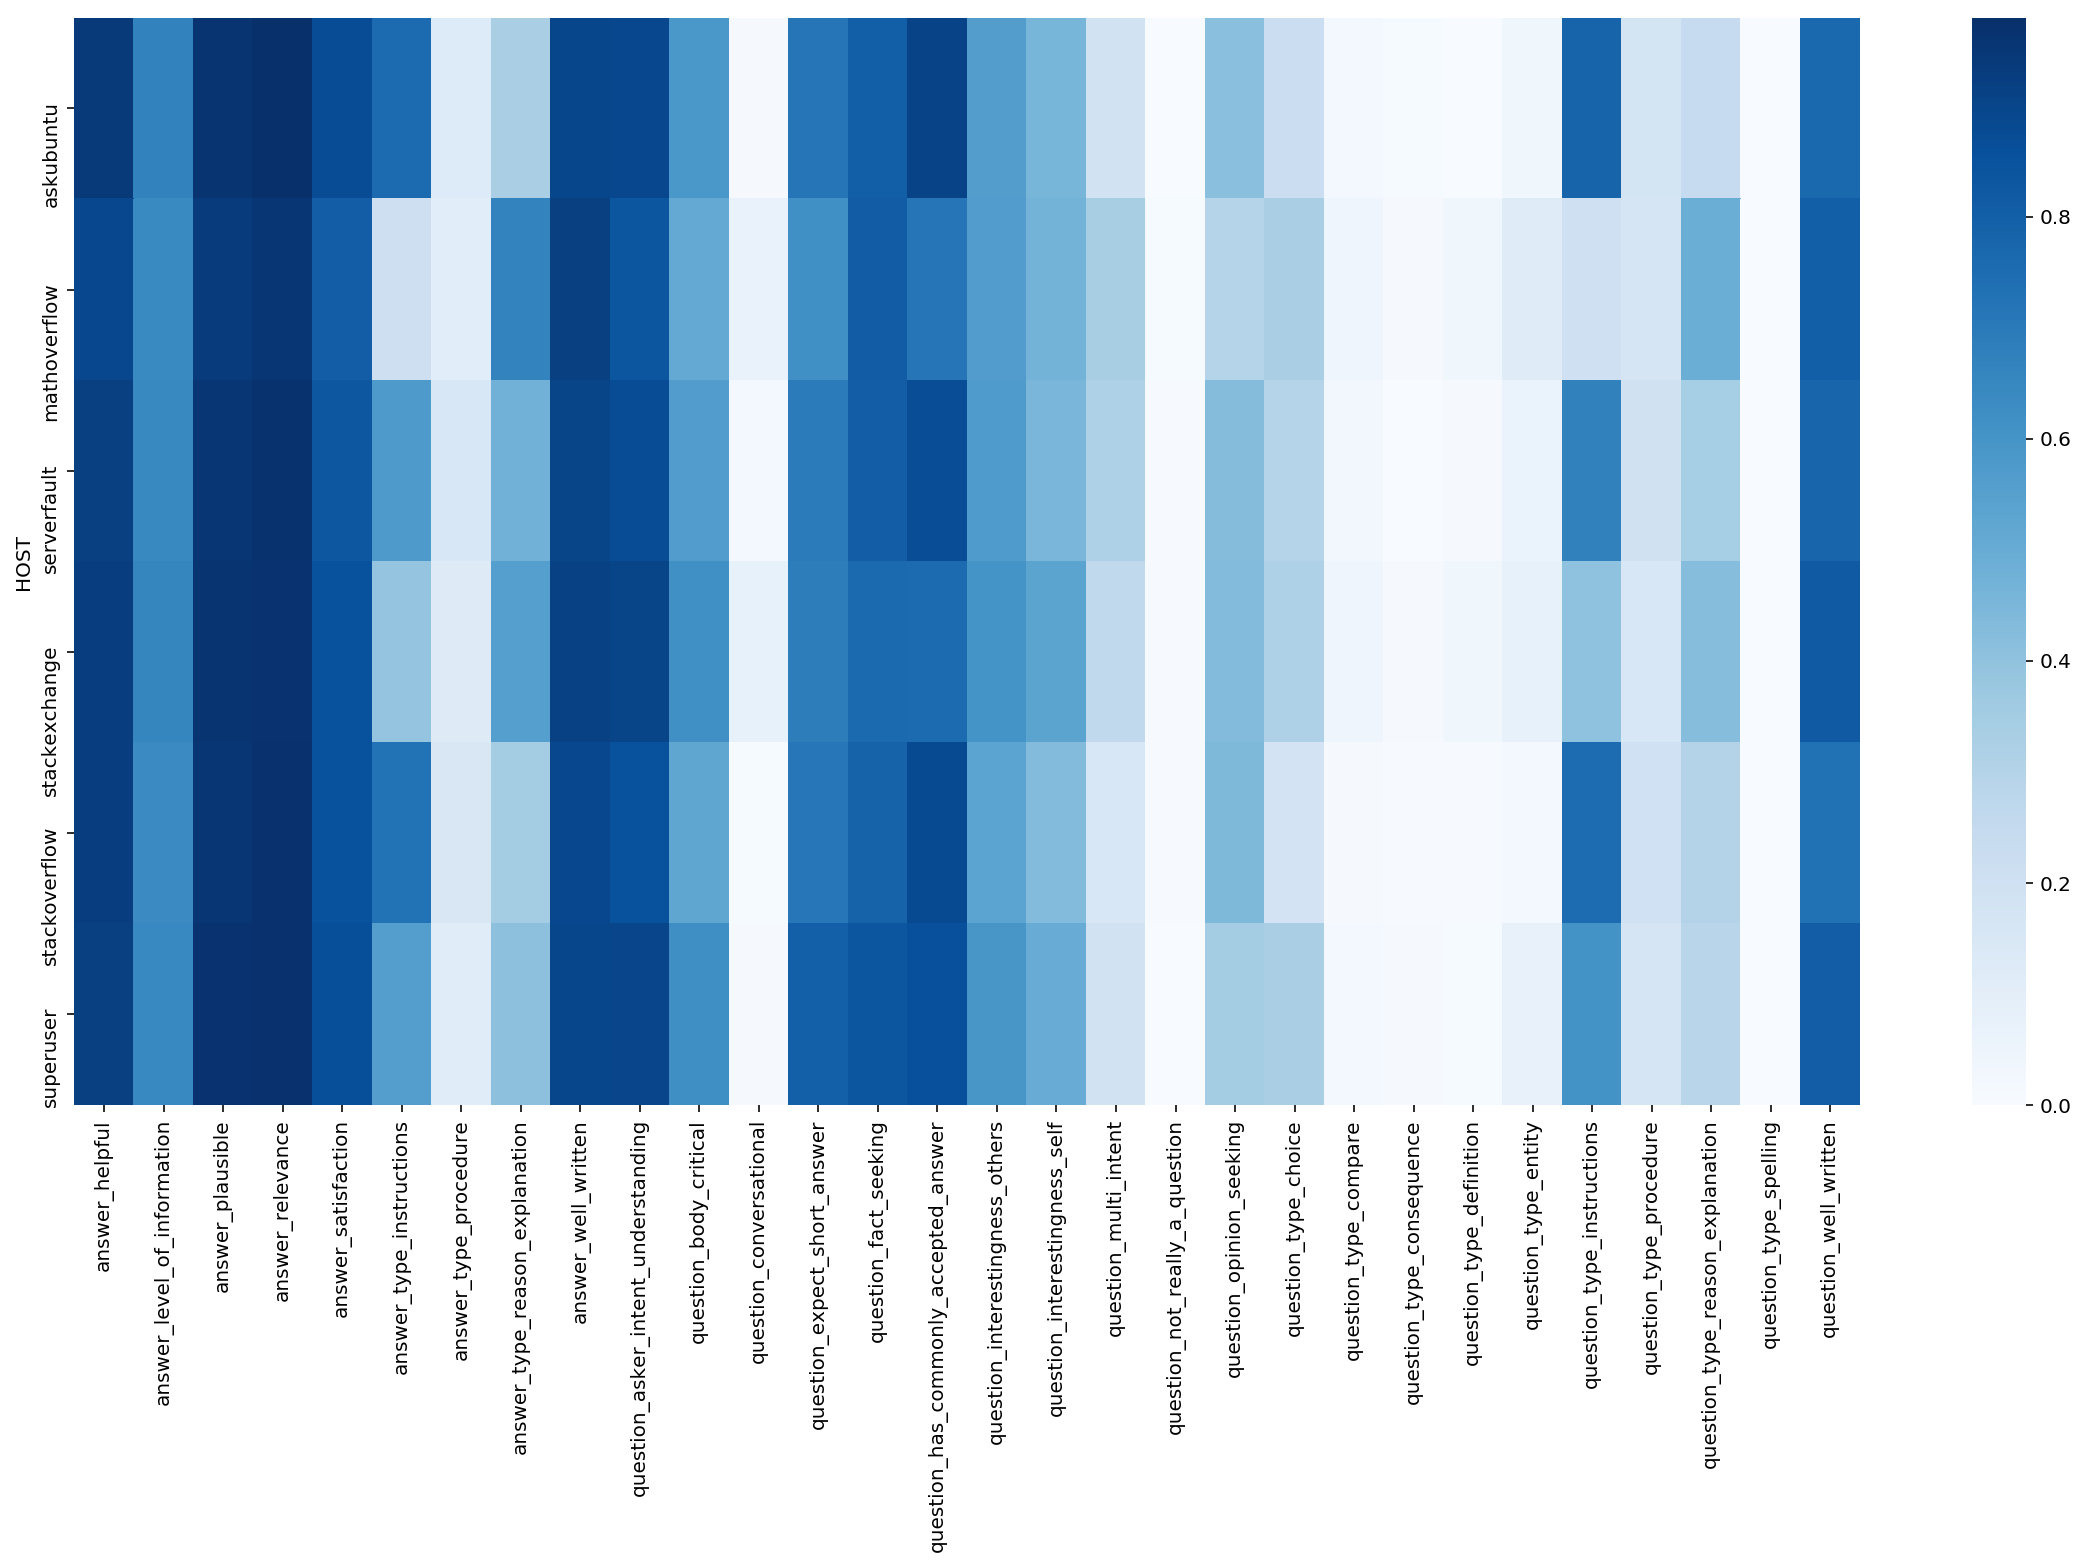

In [35]:
fig = plt.figure(figsize=(20, 10))
sns.heatmap(pd.pivot_table(index='HOST', data=trn_df, values=label_cols, aggfunc='mean'), cmap='Blues')

In [36]:
pd.pivot_table(index='HOST', data=trn_df, values=label_cols, aggfunc='count')

,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written
HOST,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
askubuntu,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128
mathoverflow,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82
serverfault,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213
stackexchange,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176,4176
stackoverflow,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253,1253
superuser,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227


In [37]:
tst_df = pd.read_csv('../mnt/inputs/origin/test.csv')

In [38]:
for HOST in HOSTs:
    tst_df.loc[tst_df.host.str.contains(HOST).values, 'HOST'] = HOST

In [41]:
tst_df.HOST.fillna('NaN').value_counts()

stackexchange    323
stackoverflow    103
superuser         17
serverfault       14
askubuntu         11
mathoverflow       8
Name: HOST, dtype: int64

## check vocab

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [81]:
# tokenizer.encode_plus(trn_df.question_body.iloc[0])
for i, token in enumerate(tokenizer.decode(tokenizer.encode_plus(trn_df.question_body.iloc[0])['input_ids']).split(' ')):
    # print(token in tokenizer.vocab)
    if token not in tokenizer.vocab:
        print(token, i)

lens, 16
rev. 17
lens, 23
), 27
this. 35
best. 54
now, 68
approaching, 72
insects. 81
this, 86
autofocus 87
settable 89
help. 95
so, 96
say, 107
ef 108
100mm 109
however, 112
lens. 122
tubes. 129
distance, 134
lens, 147
ef70 149
2. 153
lens? 160
ASAFdesafaf 162


In [83]:
tokenizer.decode(tokenizer.encode_plus(trn_df.question_body.iloc[0] + ' fdasfasfsafeaf')['input_ids'])

'[CLS] after playing around with macro photography on - the - cheap ( read : reversed lens, rev. lens mounted on a straight lens, passive extension tubes ), i would like to get further with this. the problems with the techniques i used is that focus is manual and aperture control is problematic at best. this limited my setup to still subjects ( read : dead insects ) now, as spring is approaching, i want to be able to shoot live insects. i believe that for this, autofocus and settable aperture will be of great help. so, one obvious but expensive option is a macro lens ( say, ef 100mm macro ) however, i am not really interested in yet another prime lens. an alternative is the electrical extension tubes. except for maximum focusing distance, what am i losing when using tubes ( coupled with a fine lens, say ef70 - 200 / 2. 8 ) instead of a macro lens? fdasfasfsafeaf [SEP]'

In [63]:
tokenizer.encode_plus(trn_df.question_body.iloc[0])['input_ids'][16]

10014

In [73]:
dir(tokenizer.vocab)

['__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'move_to_end',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [85]:
tokenizer.encode_plus(trn_df.question_body.iloc[0] + ' fdasfasfsafeaf')['input_ids']

[101,
 2044,
 2652,
 2105,
 2007,
 26632,
 5855,
 2006,
 1011,
 1996,
 1011,
 10036,
 1006,
 3191,
 1024,
 11674,
 10014,
 1010,
 7065,
 1012,
 10014,
 5614,
 2006,
 1037,
 3442,
 10014,
 1010,
 13135,
 5331,
 10868,
 1007,
 1010,
 1045,
 2052,
 2066,
 2000,
 2131,
 2582,
 2007,
 2023,
 1012,
 1996,
 3471,
 2007,
 1996,
 5461,
 1045,
 2109,
 2003,
 2008,
 3579,
 2003,
 6410,
 1998,
 18892,
 2491,
 2003,
 18636,
 2012,
 2190,
 1012,
 2023,
 3132,
 2026,
 16437,
 2000,
 2145,
 5739,
 1006,
 3191,
 1024,
 2757,
 9728,
 1007,
 2085,
 1010,
 2004,
 3500,
 2003,
 8455,
 1010,
 1045,
 2215,
 2000,
 2022,
 2583,
 2000,
 5607,
 2444,
 9728,
 1012,
 1045,
 2903,
 2008,
 2005,
 2023,
 1010,
 8285,
 14876,
 7874,
 1998,
 2275,
 10880,
 18892,
 2097,
 2022,
 1997,
 2307,
 2393,
 1012,
 2061,
 1010,
 2028,
 5793,
 2021,
 6450,
 5724,
 2003,
 1037,
 26632,
 10014,
 1006,
 2360,
 1010,
 1041,
 2546,
 2531,
 7382,
 26632,
 1007,
 2174,
 1010,
 1045,
 2572,
 2025,
 2428,
 4699,
 1999,
 2664,
 2178,
 353

In [94]:
list(tokenizer.vocab.keys())[17473]

'fda'

In [80]:
'lens' in tokenizer.vocab

True

In [100]:
title_lens = []
body_lens = []
answer_lens = []

for i, row in tqdm(list(trn_df.iterrows())):
    title_lens.append(len(tokenizer.encode_plus(row['question_title'])['input_ids']))
    body_lens.append(len(tokenizer.encode_plus(row['question_body'])['input_ids']))
    answer_lens.append(len(tokenizer.encode_plus(row['answer'])['input_ids']))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [101]:
trn_df['title_lens'] = title_lens
trn_df['body_lens'] = body_lens
trn_df['answer_lens'] = answer_lens

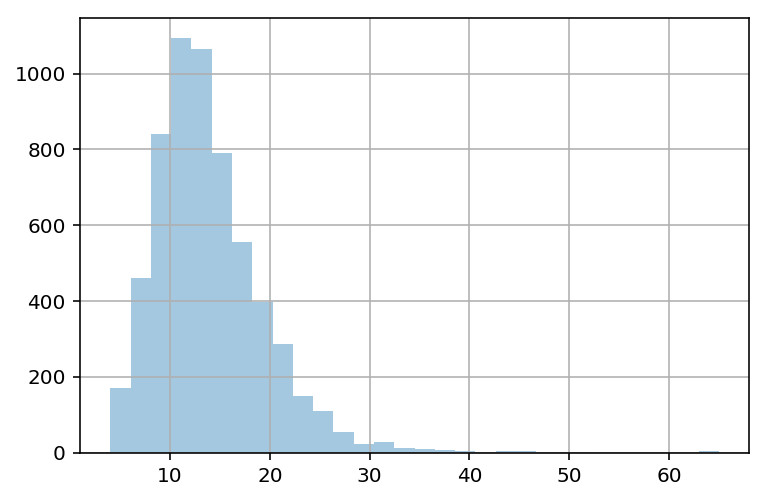

In [102]:
trn_df.title_lens.hist(bins=30, alpha=0.4)

(0, 1000)

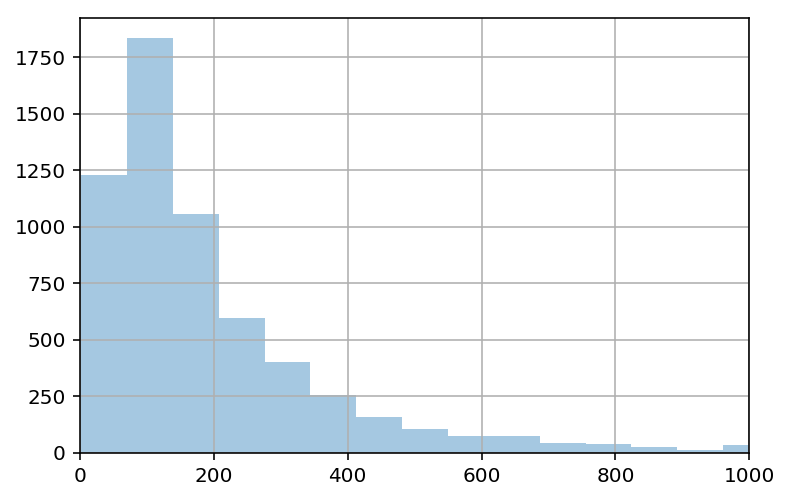

In [107]:
trn_df.body_lens.hist(bins=100, alpha=0.4)
plt.xlim(0, 1000)

(0, 1000)

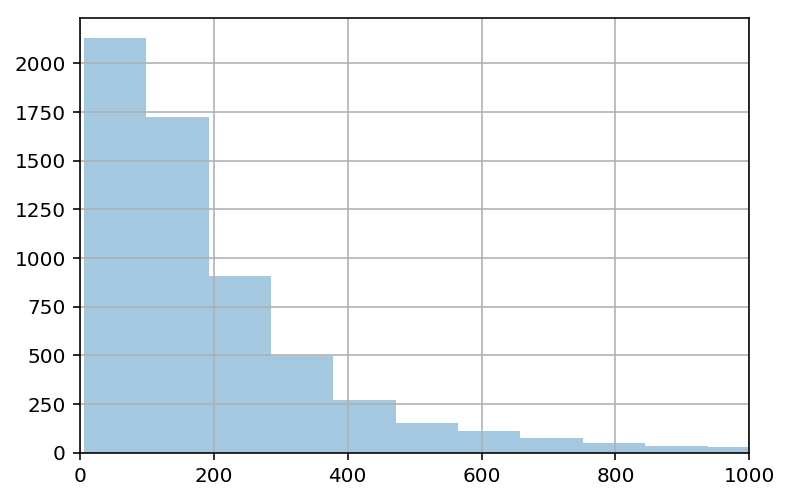

In [108]:
trn_df.answer_lens.hist(bins=100, alpha=0.4)
plt.xlim(0, 1000)

#### ちなみに host はちゃんと分かれてる...？

In [111]:
from sklearn.model_selection import GroupKFold as GKF

In [117]:
gkf = GKF(5)
for trn_idx, val_idx in gkf.split(trn_df.qa_id, trn_df.qa_id, trn_df.question_body):
    print(trn_df.iloc[val_idx].HOST.value_counts())
    print('------------------------------------------------')

stackexchange    854
stackoverflow    257
serverfault       34
superuser         29
askubuntu         27
mathoverflow      15
Name: HOST, dtype: int64
------------------------------------------------
stackexchange    840
stackoverflow    254
superuser         41
serverfault       38
askubuntu         27
mathoverflow      16
Name: HOST, dtype: int64
------------------------------------------------
stackexchange    836
stackoverflow    234
serverfault       53
superuser         45
mathoverflow      24
askubuntu         24
Name: HOST, dtype: int64
------------------------------------------------
stackexchange    829
stackoverflow    278
superuser         43
serverfault       37
askubuntu         22
mathoverflow       7
Name: HOST, dtype: int64
------------------------------------------------
stackexchange    817
stackoverflow    230
superuser         69
serverfault       51
askubuntu         28
mathoverflow      20
Name: HOST, dtype: int64
------------------------------------------------


## TFIDF つかってみる

In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [119]:
vectorizer = TfidfVectorizer()

In [123]:
base_text = [row.question_body for i, row in trn_df.iterrows()]

In [125]:
X = vectorizer.fit_transform(base_text)

In [126]:
X.shape

(6079, 30419)

## unknown check

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
tst_df = pd.read_csv('../mnt/inputs/origin/test.csv')
display(tst_df.shape, tst_df.head())

(476, 11)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,39,Will leaving corpses lying around upset my pri...,I see questions/information online about how t...,Dylan,https://gaming.stackexchange.com/users/64471,There is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com
1,46,Url link to feature image in the portfolio,I am new to Wordpress. i have issue with Featu...,Anu,https://wordpress.stackexchange.com/users/72927,I think it is possible with custom fields.\n\n...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com
2,70,"Is accuracy, recoil or bullet spread affected ...","To experiment I started a bot game, toggled in...",Konsta,https://gaming.stackexchange.com/users/37545,You do not have armour in the screenshots. Thi...,Damon Smithies,https://gaming.stackexchange.com/users/70641,http://gaming.stackexchange.com/questions/2154...,CULTURE,gaming.stackexchange.com
3,132,Suddenly got an I/O error from my external HDD,I have used my Raspberry Pi as a torrent-serve...,robbannn,https://raspberrypi.stackexchange.com/users/17341,Your Western Digital hard drive is disappearin...,HeatfanJohn,https://raspberrypi.stackexchange.com/users/1311,http://raspberrypi.stackexchange.com/questions...,TECHNOLOGY,raspberrypi.stackexchange.com
4,200,Passenger Name - Flight Booking Passenger only...,I have bought Delhi-London return flights for ...,Amit,https://travel.stackexchange.com/users/29089,I called two persons who work for Saudia (tick...,Nean Der Thal,https://travel.stackexchange.com/users/10051,http://travel.stackexchange.com/questions/4704...,CULTURE,travel.stackexchange.com


#### question title

In [24]:
title_words = []
body_words = []
answer_words = []

for i, row in tqdm(list(trn_df.iterrows())):
    title_words.append(tokenizer.tokenize(row['question_title']))
    body_words.append(tokenizer.tokenize(row['question_body']))
    answer_words.append(tokenizer.tokenize(row['answer']))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [37]:
import itertools 
all_title_words = list(itertools.chain.from_iterable(title_words))
all_body_words = list(itertools.chain.from_iterable(body_words))
all_answer_words = list(itertools.chain.from_iterable(answer_words))

In [43]:
all_title_seqlens = [len(seq) for seq in title_words]
all_body_seqlens = [len(seq) for seq in body_words]
all_answer_seqlens = [len(seq) for seq in answer_words]

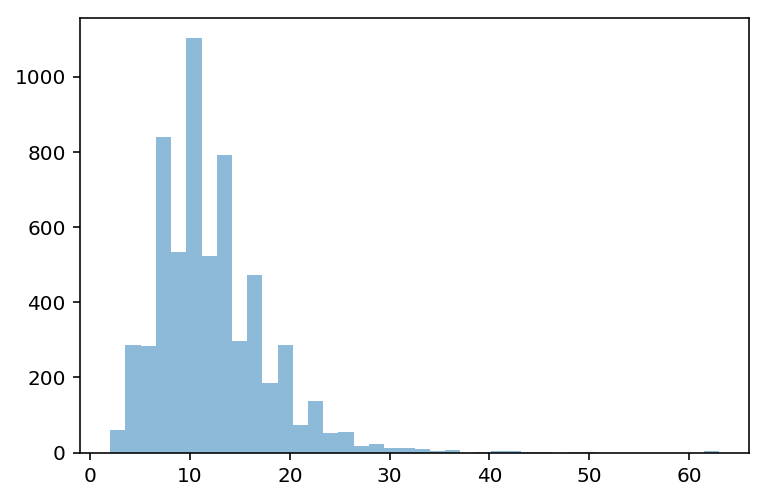

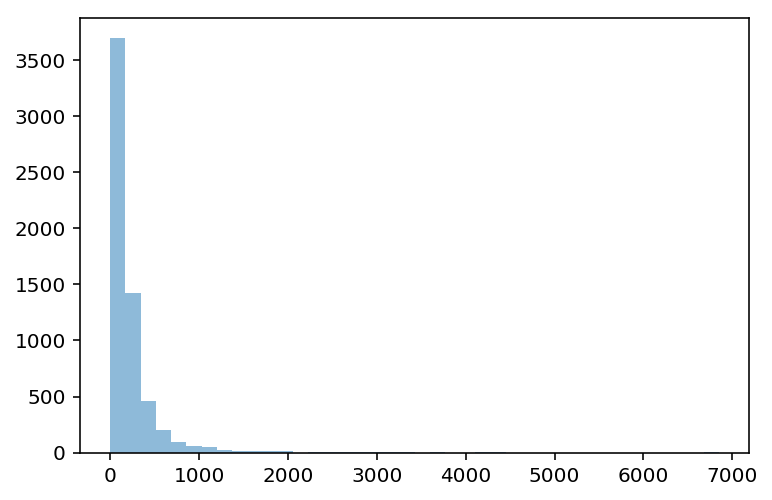

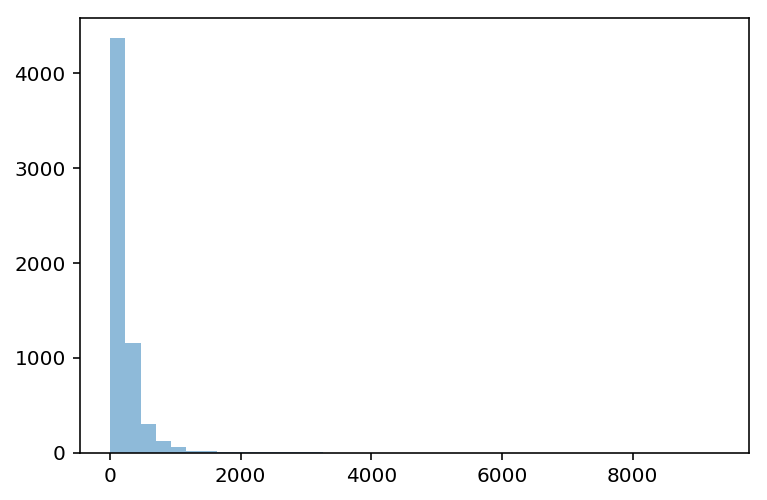

In [46]:
plt.hist(all_title_seqlens, bins=40, alpha=0.5)
plt.show()
plt.hist(all_body_seqlens, bins=40, alpha=0.5)
plt.show()
plt.hist(all_answer_seqlens, bins=40, alpha=0.5)
plt.show()

In [52]:
print((np.array(all_title_seqlens) < 30).sum() / len(all_title_seqlens))
print((np.array(all_body_seqlens) < 239).sum() / len(all_body_seqlens))
print((np.array(all_answer_seqlens) < 239).sum() / len(all_answer_seqlens))

0.9901299555848001
0.7323572956078302
0.721335746010857


In [27]:
dir(tokenizer)

['SPECIAL_TOKENS_ATTRIBUTES',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_additional_special_tokens',
 '_bos_token',
 '_cls_token',
 '_convert_id_to_token',
 '_convert_token_to_id',
 '_convert_token_to_id_with_added_voc',
 '_eos_token',
 '_from_pretrained',
 '_mask_token',
 '_pad_token',
 '_pad_token_type_id',
 '_sep_token',
 '_tokenize',
 '_unk_token',
 'add_special_tokens',
 'add_tokens',
 'added_tokens_decoder',
 'added_tokens_encoder',
 'additional_special_tokens',
 'additional_special_tokens_ids',
 'all_special_ids',
 'all_special_tokens',
 'basic_tokenizer',
 'batch_encode_plus',
 'bos_token',
 'bos_token_id',
 'build_inputs_with_special_tokens'

In [30]:
from collections import Counter

In [38]:
cnt = Counter([word for word in all_body_words if '##' in word])

In [39]:
cnt

Counter({'##fo': 315,
         '##cus': 53,
         '##table': 138,
         '##f': 1166,
         '##mm': 169,
         '##70': 72,
         '##m': 1239,
         '##run': 81,
         '##ra': 89,
         '##wl': 14,
         '##ex': 506,
         '##plex': 6,
         '##sities': 2,
         '##b': 1115,
         '##rin': 21,
         '##s': 5623,
         '##ered': 10,
         '##2': 1987,
         '##4': 793,
         '##manship': 1,
         '##fi': 840,
         '##dav': 15,
         '##it': 274,
         '##chrome': 3,
         '##icia': 6,
         '##te': 291,
         '##que': 297,
         '##ry': 345,
         '##arat': 9,
         '##ors': 61,
         '##bu': 1054,
         '##nt': 809,
         '##u': 716,
         '##imi': 61,
         '##t': 1806,
         '##g': 1491,
         '##yte': 22,
         '##59': 66,
         '##si': 165,
         '##x': 2260,
         '##9': 1266,
         '##200': 45,
         '##trick': 7,
         '##on': 336,
         '##lin': 16,
  

In [42]:
trn_df.iloc[0]['question_body'].split('.')

['After playing around with macro photography on-the-cheap (read: reversed lens, rev',
 ' lens mounted on a straight lens, passive extension tubes), I would like to get further with this',
 ' The problems with the techniques I used is that focus is manual and aperture control is problematic at best',
 ' This limited my setup to still subjects (read: dead insects) Now, as spring is approaching, I want to be able to shoot live insects',
 ' I believe that for this, autofocus and settable aperture will be of great help',
 '\n\nSo, one obvious but expensive option is a macro lens (say, EF 100mm Macro) However, I am not really interested in yet another prime lens',
 ' An alternative is the electrical extension tubes',
 '\n\nExcept for maximum focusing distance, what am I losing when using tubes (coupled with a fine lens, say EF70-200/2',
 '8) instead of a macro lens?\n']

In [54]:
long_trn_df = trn_df.loc[(np.array(all_body_seqlens) < 239)]

In [61]:
for i, row in long_trn_df.sample(20, random_state=71).iterrows():
    print(' ---------------------------------------------------------- ')
    print(f'CATEGORY : {row["category"]} -- HOST : {row["host"]}')
    print(' ---------------------------------------------------------- ')
    print(' ')
    print(' ------------ Title ------------')
    print(row['question_title'])
    print(' ')
    print(' ------------ Question ------------')
    print(row['question_body'])
    print(' ')
    print(' ------------ Answer ------------')
    print(row['answer'])
    print(' ')
    print(' ')

 ---------------------------------------------------------- 
CATEGORY : STACKOVERFLOW -- HOST : stackoverflow.com
 ---------------------------------------------------------- 
 
 ------------ Title ------------
Alternative Date/Time Libraries for Go
 
 ------------ Question ------------
Are there any alternatives to Golang's time package? I can't come to grips with its clunky interface and strange way of doing things. The language overall is great, but this part of it just never clicked with me.

Anyone? A really good, thorough tutorial would work too (I have not managed to find one yet)

What I'm trying to do right now is a goroutine that updates only 10 times per second (or any variable interval that I set it to). I've not yet implemented it, as the package is not playing nice. Here's the psuedo code.

function GoRoutine(updatesPerSecond int) {
    interval = 1000msec / updatesPerSecond

    for {
        if enoughTimeHasPassed {
            doThings()
        }
    }
}


 
 ---------

In [58]:
short_trn_df = trn_df.loc[~(np.array(all_body_seqlens) < 239)]

In [62]:
for i, row in short_trn_df.sample(20, random_state=71).iterrows():
    print(' ---------------------------------------------------------- ')
    print(f'CATEGORY : {row["category"]} -- HOST : {row["host"]}')
    print(' ---------------------------------------------------------- ')
    print(' ------------ Title ------------')
    print(row['question_title'])
    print(' ')
    print(' ------------ Question ------------')
    print(row['question_body'])
    print(' ')
    print(' ------------ Answer ------------')
    print(row['answer'])
    print(' ')
    print(' ')

 ---------------------------------------------------------- 
CATEGORY : CULTURE -- HOST : rpg.stackexchange.com
 ---------------------------------------------------------- 
 ------------ Title ------------
Are there any good, free introductory Dungeon World adventures for a DM used to D&D?
 
 ------------ Question ------------
I have been playing &amp; GMing for some time, mostly in various versions of D&amp;D, and other 80s-90s systems. And most of my GMing has been with published adventure modules.

I want to try Dungeon World, so have been looking for a free adventure that would work as an introduction to the system (for both the players and myself). But most of what I can find are "Dungeon Starters":


  Dungeon Starters are a form of GM prep for running the first session of a Dungeon World game. Dungeon Starters don’t dictate plot, they’re not Fronts (you write those after the first session), and they don’t replace the GM playbook. They are for those times when you want to just si

In [65]:
model = BertModel.from_pretrained('bert-base-uncased')
model.config

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}